In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path ="/content/drive/MyDrive/fruits-360-original-size/fruits-360-original-size/Training"
import os
import numpy as np
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# Function to load images and labels
def load_images_and_labels(train_path):
    x_train = []
    y_train = []

    # Iterate through each folder (class) in the training path
    for folder_name in os.listdir(train_path):
        folder_path = os.path.join(train_path, folder_name)

        # Check if the path is a directory
        if os.path.isdir(folder_path):
            # Iterate through each image in the folder
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)

                # Load the image and resize it to your desired size
                img = image.load_img(img_path, target_size=(your_desired_width, your_desired_height))
                img_array = image.img_to_array(img)

                # Append the image array to x_train
                x_train.append(img_array)

                # Append the label (folder name) to y_train
                y_train.append(folder_name)

    return np.array(x_train), np.array(y_train)

# Specify your desired image dimensions
your_desired_width = 128
your_desired_height = 128



# Load images and labels
x_train, y_train = load_images_and_labels(train_path)



print(x_train.shape)
print(y_train.shape)






(6231, 128, 128, 3)
(6231,)


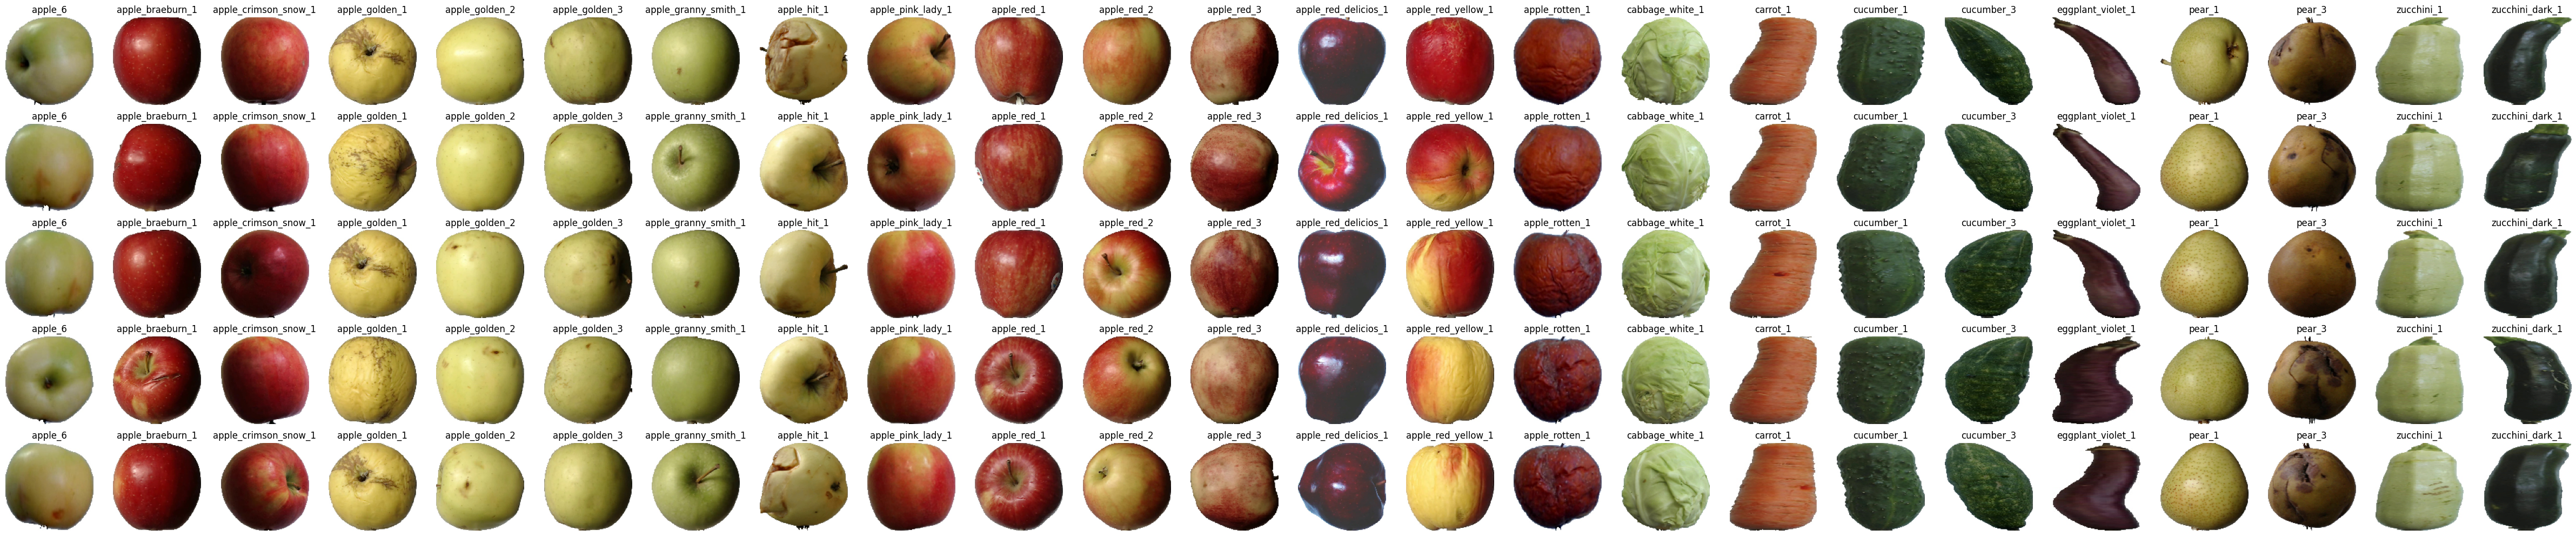

In [ ]:
import matplotlib.pyplot as plt

# Display a few samples with their labels
def plot_samples(x_train, y_train, num_samples=5):
    # Get unique labels/classes in the dataset
    unique_labels = np.unique(y_train)

    # Create a figure and axis
    fig, axes = plt.subplots(num_samples, len(unique_labels), figsize=(len(unique_labels) * 2, num_samples * 2))

    for i, label in enumerate(unique_labels):
        # Get indices of samples with the current label
        label_indices = np.where(y_train == label)[0]

        # Randomly select num_samples indices
        selected_indices = np.random.choice(label_indices, num_samples, replace=False)

        for j, index in enumerate(selected_indices):
            # Display the image
            axes[j, i].imshow(x_train[index].astype(np.uint8))
            axes[j, i].axis('off')
            axes[j, i].set_title(label)

    plt.tight_layout()
    plt.show()

# Plot samples
plot_samples(x_train, y_train)

In [ ]:

# Convert string labels to integer labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Flatten y_train to make it 1D
y_train_flattened = y_train_encoded.ravel()

# Function to preprocess images and labels
def preprocess_data(x, y):
    # Normalize pixel values to the range [0, 1]
    x = x / 255.0

    # You can add additional preprocessing steps if needed

    return x, y




# Preprocess the data
x_train, y_train_flattened = preprocess_data(x_train, y_train_flattened)

# Print the shape of x_train and y_train_flattened after preprocessing
print("Shape of x_train after preprocessing:", x_train.shape)
print("Shape of y_train_flattened after preprocessing:", y_train_flattened.shape)

# Print the shape of the training and validation sets after splitting
print("Shape of x_train :", x_train.shape)

print("Shape of y_train :", y_train.shape)

Shape of x_train after preprocessing: (6231, 128, 128, 3)
Shape of y_train_flattened after preprocessing: (6231,)
Shape of x_train after splitting: (6231, 128, 128, 3)
Shape of y_train after splitting: (6231,)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the already-trained layers in the model
for layer in vgg16_model.layers:
    layer.trainable = False

# Create your custom model
model = Sequential()
model.add(vgg16_model)
model.add(GlobalAveragePooling2D())

# Add your own layers if needed
# For example, you can add Dense layers here.

model.summary()

# Assuming x_train is your training data
feature_train_vgg = model.predict(x_train)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
195/195 [==============================] - 8s 38ms/step


In [ ]:
print(feature_train_vgg.shape)
# Flatten extracted features
flat_train_vgg_flatten = feature_train_vgg.reshape(feature_train_vgg.shape[0], -1)
print(flat_train_vgg_flatten.shape)

(6231, 512)
(6231, 512)


In [ ]:
# use genatic algorithm to find best features to use
from sklearn.svm import SVC
# Genetic Algorithm Parameters
POP_SIZE = 3
GENES = flat_train_vgg_flatten.shape[1]
GENERATIONS = 5
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.7
AVERAGE_ACC = [] # Average accuracy of each generation

# Initialize population
def initialize_population(population_size, genes):
    return np.random.choice([0, 1], size=(population_size, genes))

# Evaluate fitness using nn classifier
def evaluate_fitness(population, X_train, X_test, y_train, y_test):
    fitness_values = []
    for chromosome in population:
        selected_features = np.where(chromosome == 1)[0]
        if len(selected_features) == 0:
            fitness_values.append(0)
            continue
        X_train_selected = X_train[:, selected_features]
        X_test_selected = X_test[:, selected_features]
        model = SVC(kernel='poly', C=1)
        model.fit(X_train_selected, y_train)
        test_acc = model.score(X_test_selected, y_test)
        print('Acc:', test_acc)
        fitness_values.append(test_acc)

    return np.array(fitness_values)

# Perform crossover
def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

# Perform mutation
def mutate(child):
    mutation_mask = np.random.rand(len(child)) < MUTATION_RATE
    child[mutation_mask] = 1 - child[mutation_mask]  # Flip the bits
    return child

# Main Genetic Algorithm
def genetic_algorithm(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    population = initialize_population(POP_SIZE, GENES)

    for generation in range(GENERATIONS):
        print(f'=========================================== generation:{generation} =========================================== ')
        fitness_values = evaluate_fitness(population, X_train, X_test, y_train, y_test)
        selected_indices = np.argsort(fitness_values)[::-1][:int(POP_SIZE * CROSSOVER_RATE)]

        new_population = []
        AVERAGE_ACC.append(np.mean(fitness_values))
        # Perform crossover and mutation
        for _ in range(0, POP_SIZE, 2):
            parent1 = population[np.random.choice(selected_indices)]
            parent2 = population[np.random.choice(selected_indices)]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_population.extend([child1, child2])

        population = np.array(new_population)

    best_individual = population[np.argmax(fitness_values)]
    selected_features = np.where(best_individual == 1)[0]
    return selected_features

# usage
selected_features = genetic_algorithm(flat_train_vgg_flatten, y_train_flattened)
print("Selected Features:", selected_features)

=========================================== generation:0 =========================================== 
Acc: 0.9478748997594226
Acc: 1.0
Acc: 0.9767441860465116
=========================================== generation:1 =========================================== 
Acc: 0.9655172413793104
Acc: 1.0
Acc: 0.9767441860465116
Acc: 0.9727345629510826
=========================================== generation:2 =========================================== 
Acc: 0.9991980753809142
Acc: 0.9719326383319968
Acc: 1.0
Acc: 1.0
=========================================== generation:3 =========================================== 
Acc: 1.0
Acc: 0.9679230152365678
Acc: 0.9983961507618284
Acc: 0.9991980753809142
=========================================== generation:4 =========================================== 
Acc: 1.0
Acc: 1.0
Acc: 0.9983961507618284
Acc: 0.9991980753809142
Selected Features: [  0   1   2   5   8   9  10  11  12  13  15  18  20  22  23  24  27  28
  29  30  31  32  33  37  40  42  50  51  53  5

In [ ]:
print(len(selected_features))
print(len(feature_train_vgg))

253
6231


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Assuming feature_train_vgg is your feature set and y_train is your labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_train_vgg, y_train, test_size=0.2, random_state=42)

# Train an SVM model with a polynomial kernel
model = SVC(kernel='poly', C=1)
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_acc = model.score(X_test, y_test)
print('Accuracy:', test_acc)

# Predict on the test data
predictions = model.predict(X_test)
print('Predictions:', predictions)

# Classification report
print(classification_report(y_test, predictions))


Accuracy: 0.9903769045709703
Predictions: ['cucumber_3' 'apple_red_1' 'apple_pink_lady_1' ... 'apple_crimson_snow_1'
 'apple_red_1' 'apple_golden_2']
                      precision    recall  f1-score   support

             apple_6       1.00      1.00      1.00        75
    apple_braeburn_1       1.00      0.97      0.99        78
apple_crimson_snow_1       0.91      1.00      0.95        51
      apple_golden_1       1.00      1.00      1.00        67
      apple_golden_2       0.97      1.00      0.99        73
      apple_golden_3       1.00      0.97      0.98        59
apple_granny_smith_1       0.95      1.00      0.98        63
         apple_hit_1       1.00      1.00      1.00        89
   apple_pink_lady_1       1.00      0.91      0.95        53
         apple_red_1       1.00      1.00      1.00        61
         apple_red_2       0.97      1.00      0.99        69
         apple_red_3       1.00      1.00      1.00        53
apple_red_delicios_1       1.00      1.00  

In [ ]:
test_path = "/content/drive/MyDrive/fruits-360-original-size/fruits-360-original-size/Test"

# Function to load images and labels for the test dataset
def load_test_images_and_labels(test_path, label_encoder):
    x_test = []
    y_test = []

    # Iterate through each folder (class) in the test path
    for folder_name in os.listdir(test_path):
        folder_path = os.path.join(test_path, folder_name)

        # Check if the path is a directory
        if os.path.isdir(folder_path):
            # Iterate through each image in the folder
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)

                # Load the image and resize it to your desired size
                img = image.load_img(img_path, target_size=(your_desired_width, your_desired_height))
                img_array = image.img_to_array(img)

                # Append the image array to x_test
                x_test.append(img_array)

                # Append the label (folder name) to y_test
                y_test.append(folder_name)

    # Encode the labels using the label_encoder fitted on the training data
    y_test_encoded = label_encoder.transform(y_test)

    return np.array(x_test), np.array(y_test_encoded)

# Load test images and labels
x_test, y_test = load_test_images_and_labels(test_path, label_encoder)

# Print the shapes of the test data
print(x_test.shape)
print(y_test.shape)





(3110, 128, 128, 3)
(3110,)


In [ ]:

# Convert string labels to integer labels using LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Flatten y_train to make it 1D
y_test_flattened = y_test_encoded.ravel()

# Function to preprocess images and labels
def preprocess_data(x, y):
    # Normalize pixel values to the range [0, 1]
    x = x / 255.0

    # You can add additional preprocessing steps if needed

    return x, y




# Preprocess the data
x_test, y_test_flattened = preprocess_data(x_test, y_test_flattened)

# Print the shape of x_test and y_train_flattened after preprocessing
print("Shape of x_test after preprocessing:", x_test.shape)
print("Shape of y_test_flattened after preprocessing:", y_test_flattened.shape)

# Print the shape of the training and validation sets after splitting
print("Shape of x_train after splitting:", x_test.shape)

print("Shape of y_train after splitting:", y_test_flattened.shape)

Shape of x_test after preprocessing: (3110, 128, 128, 3)
Shape of y_test_flattened after preprocessing: (3110,)
Shape of x_train after splitting: (3110, 128, 128, 3)
Shape of y_train after splitting: (3110,)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the already-trained layers in the model
for layer in vgg16_model.layers:
    layer.trainable = False

# Create your custom model
model = Sequential()
model.add(vgg16_model)
model.add(GlobalAveragePooling2D())

# Add your own layers if needed
# For example, you can add Dense layers here.

model.summary()

# Assuming x_train is your training data
feature_test_vgg = model.predict(x_test)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
98/98 [==============================] - 4s 40ms/step


In [ ]:
print(feature_test_vgg.shape)
# Flatten extracted features
flat_test_vgg_flatten = feature_test_vgg.reshape(feature_test_vgg.shape[0], -1)
print(flat_test_vgg_flatten.shape)

(3110, 512)
(3110, 512)


In [ ]:
selected_features = genetic_algorithm(flat_test_vgg_flatten, y_test_flattened)
print("Selected Features test:", selected_features)

=========================================== generation:0 =========================================== 
Acc: 0.9726688102893891
Acc: 0.9790996784565916
Acc: 0.8906752411575563
=========================================== generation:1 =========================================== 
Acc: 0.9598070739549839
Acc: 0.9726688102893891
Acc: 0.977491961414791
Acc: 0.9790996784565916
=========================================== generation:2 =========================================== 
Acc: 0.9758842443729904
Acc: 0.9887459807073955
Acc: 0.977491961414791
Acc: 0.9807073954983923
=========================================== generation:3 =========================================== 
Acc: 0.9823151125401929
Acc: 0.9807073954983923
Acc: 0.9823151125401929
Acc: 0.9839228295819936
=========================================== generation:4 =========================================== 
Acc: 0.9823151125401929
Acc: 0.9662379421221865
Acc: 0.9790996784565916
Acc: 0.9839228295819936
Selected Features test: [  2  12  13

In [ ]:
print(len(selected_features))
print(len(feature_test_vgg))

220
3110


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming flat_test_vgg_flatten is your feature data and y_test_flattened is your target labels
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(flat_test_vgg_flatten[:, selected_features], y_test_flattened, test_size=0.2, random_state=42)

# Initialize an SVM classifier
svm_classifier = SVC()

# Train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = svm_classifier.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.9678456591639871


In [ ]:
# # confusion matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, predictions)
# # heatmap
# plt.figure(figsize=(10,10))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming X_test has two features (you can modify this based on your data)
# X_test_2d = X_test[:, :2]

# # Scatter plot for true labels
# plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap='viridis', marker='o', label='True Labels')

# # Scatter plot for predicted labels
# plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=predictions, cmap='viridis', marker='x', label='Predicted Labels')

# # Adding labels and legend
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('True and Predicted Labels')
# plt.legend()

# # Show the plot
# plt.show()


In [ ]:
# classification report
print(predictions.shape)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

(622,)
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        37
           1       0.95      0.92      0.94        39
           2       0.90      0.97      0.94        39
           3       0.95      0.95      0.95        38
           4       0.89      1.00      0.94        25
           5       0.94      0.94      0.94        33
           6       0.94      1.00      0.97        31
           7       1.00      1.00      1.00        41
           8       0.96      0.84      0.90        31
           9       1.00      1.00      1.00        31
          10       0.87      0.93      0.90        29
          11       1.00      1.00      1.00        28
          12       1.00      1.00      1.00        29
          13       1.00      0.89      0.94        28
          14       1.00      1.00      1.00        31
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         9
          17       1